<a href="https://colab.research.google.com/github/Voland24/AndrewNGDeepLearningCourse/blob/main/DataClassificationOneHiddenLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Helper functions for loading and displaying data


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model


def plot_decision_boundary(model, X, y, single=True):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.5)
    # plt.ylabel('x2')
    # plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.Spectral)
    if single:
        plt.show()


def sigmoid(x):
    """
    Compute the sigmoid of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(x)
    """
    s = 1 / (1 + np.exp(-x))
    return s


def load_planar_dataset():
    np.random.seed(1)
    m = 400  # number of examples
    N = int(m / 2)  # number of points per class
    D = 2  # dimensionality
    X = np.zeros((m, D))  # data matrix where each row is a single example
    Y = np.zeros((m, 1), dtype='uint8')  # labels vector (0 for red, 1 for blue)
    a = 4  # maximum ray of the flower

    for j in range(2):
        ix = range(N * j, N * (j + 1))
        t = np.linspace(j * 3.12, (j + 1) * 3.12, N) + np.random.randn(N) * 0.2  # theta
        r = a * np.sin(4 * t) + np.random.randn(N) * 0.2  # radius
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y


def load_extra_datasets():
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2,
                                                                  n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)

    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

Test case helper functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline

np.random.seed(1)

Load planar dataset

(2, 400)
(1, 400)


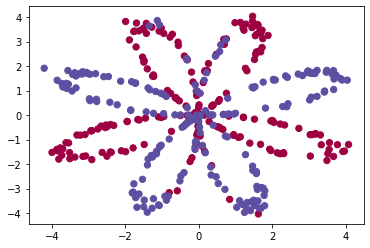

In [9]:
X, Y = load_planar_dataset()
print(X.shape)
print(Y.shape)
m = Y.shape[1] #number of training examples
plt.scatter(X[0,:], X[1:], c= Y, s = 40, cmap = plt.cm.Spectral)


Seeing how an ordinary logistic regression works on this problem

In [10]:
model = sklearn.linear_model.LogisticRegressionCV()
model.fit(X.T, Y.T)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV()

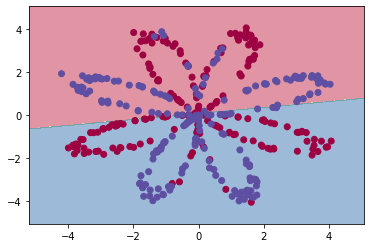

Accuracy is 47.0


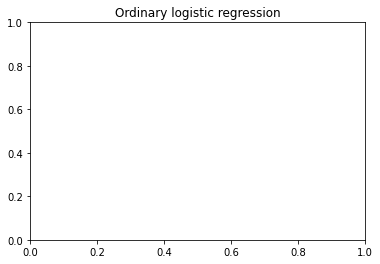

In [12]:
plot_decision_boundary(lambda x: model.predict(x), X , Y)
plt.title("Ordinary logistic regression")

predictions = model.predict(X.T)
print(f"Accuracy is {float((np.dot(Y, predictions) + np.dot(1 - Y,1 - predictions)) / float(Y.size) * 100)}")

What we see is that the logistic regression cannot correctly "model" the data since the data isn't linearly separable. We need a neural network

Defining the structure of our NN

In [13]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """

    n_x = X.shape[0] # size of the input layer i.e. 2 inputs
    n_h = 4 #4 neurons in the hidden layer
    n_y = Y.shape[0] #size of the output layer i.e 1

    return (n_x, n_h, n_y)


Initialize parameters of our network

In [14]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """

    np.random.seed(2)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape = (n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape = (n_y, 1))

    params = {
        "W1": W1,
        "b1" : b1,
        "W2" : W2,
        "b2" : b2
    }

    return params


Implementing the forward pass function

In [15]:
def forward_propagation(X, params):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """

    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]

    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1)
    A2 = sigmoid(Z2)

    cache = {
        "Z1" : Z1,
        "A1" : A1,
        "Z2" : Z2,
        "A2" : A2
    }

    return A2, cache

Now we implement the cost function used to evaluate our model. Since this is a binary classification problem, we will use a binary cross entropy loss function

In [28]:
def compute_cost(A2, Y, params):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """

    m = Y.shape[1] #number of examples in dataset

    cost = (-1 / m) * (np.dot(np.log(A2), Y.T) + np.dot(np.log(1 - A2), (1 - Y).T))

    cost = np.squeeze(cost)

    return cost


Since we have the loss function and the forward pass defined, and we cache te values neccessary for computing the backward pass, we can implement the backward pass

In [20]:
def backward_propagation(params, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """

    m = Y.shape[1] #number of examples

    W1 = params["W1"]
    W2 = params["W2"]

    A1 = cache["A1"]
    A2 = cache["A2"]

    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis = 1, keepdims = True)

    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1,2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis = 1, keepdims = True)
    
    grads = {
        "dW1" : dW1,
        "db1" : db1,
        "dW2" : dW2,
        "db2" : db2
    }

    return grads


Implement gradient descent i.e. implement the update fucntion with a given learning rate

In [21]:
def update_parameters(params, grads, learning_rate = 1.2):
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]

    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    params = {
        "W1": W1,
        "b1" : b1,
        "W2" : W2,
        "b2" : b2
    }

    return params

Put all of this into one function i.e create the model

In [22]:
def nn_model(X, Y, n_h, num_iter = 10000, print_cost = False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(3)
    n_x, _, n_y = layer_sizes(X,Y)

    params = initialize_parameters(n_x, n_h, n_y)
    W1 = params["W1"]
    W2 = params["W2"]
    b1 = params["b1"]
    b2 = params["b2"]

    for i in range(num_iter):
      A2, cache = forward_propagation(X, params)
      cost = compute_cost(A2, Y, params)
      grads = backward_propagation(params, cache, X, Y)
      params = update_parameters(params,grads)

      if print_cost and i%1000 == 0:
        print(f"Cost after {i}. iter is {cost}")
    
    return params

Predict with the NN model

In [23]:
def predict(params, X):
    A2, cache = forward_propagation(X, params)
    predictions = np.round(A2) #anything smaller than 0.5 is 0 else it's 1
    return predictions

Build a model and see its performance

Cost after 0. iter is 0.6930480201239825
Cost after 1000. iter is 0.2881250672188695
Cost after 2000. iter is 0.25641152039058956
Cost after 3000. iter is 0.23404808878051137
Cost after 4000. iter is 0.22692216798199552
Cost after 5000. iter is 0.22276468773347424
Cost after 6000. iter is 0.2198517880806441
Cost after 7000. iter is 0.2176290587853795
Cost after 8000. iter is 0.21586282111458116
Cost after 9000. iter is 0.21859041693229828


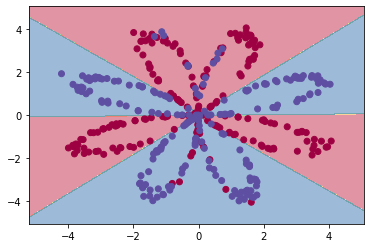

Text(0.5, 1.0, 'Decision boundary for NN with a hidden layer of size 4')

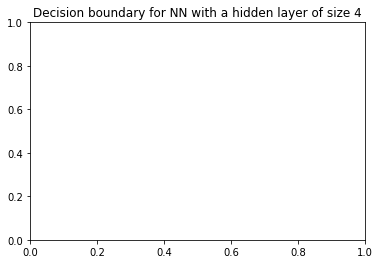

In [29]:
params = nn_model(X, Y,n_h = 4,num_iter = 10000,print_cost = True)

plot_decision_boundary(lambda x: predict(params, x.T), X, Y)
plt.title("Decision boundary for NN with a hidden layer of size 4")

We see how a nonlinear model can find better decision boundary better suited for the given data

In [32]:
preds = predict(params,X)
print(f"Accuracy is {(float((np.dot(Y, preds.T) + np.dot( (1 - Y), (1 - preds).T) ) / float(Y.size)) * 100)}")


Accuracy is 90.5


Lets try to find a different number of neurons in the hidden layer

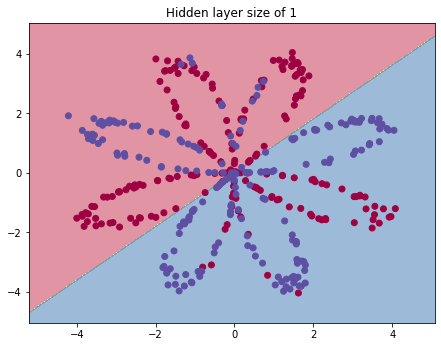

Accuracy for 1 hidden neurons is 67.5


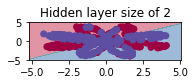

Accuracy for 2 hidden neurons is 67.5


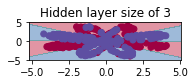

Accuracy for 3 hidden neurons is 90.75


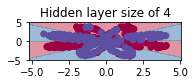

Accuracy for 4 hidden neurons is 90.5


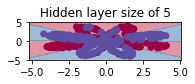

Accuracy for 5 hidden neurons is 91.25


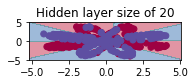

Accuracy for 20 hidden neurons is 90.5


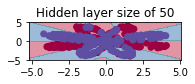

Accuracy for 50 hidden neurons is 90.75


In [34]:
plt.figure(figsize = (16,32))
hidden_layer_sizes = [1,2,3,4,5,20,50]
for i, n_h in enumerate(hidden_layer_sizes):
  plt.subplot(5,2,i+1)
  plt.title(f"Hidden layer size of {n_h}")
  params = nn_model(X, Y, n_h, num_iter = 5000)
  plot_decision_boundary(lambda x: predict(params,x.T), X, Y)
  preds = predict(params, X)
  acc = (float((np.dot(Y, preds.T) + np.dot( (1 - Y), (1 - preds).T) ) / float(Y.size)) * 100)
  print(f"Accuracy for {n_h} hidden neurons is {acc}")

We see that the models with 3,4,5 hidden units perform great overall without much overfitting
We also see how with 20,50 neurons there is great overfitting. This can be mitigated with regularization